# Load file

In [ ]:
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

In [2]:
df_path = "C:/Users/Enduser/OneDrive - Asia Pacific University/uni/Y3S2/fyp/Model_trial/btc_trial_dataset2.csv"
dataset_df = pd.read_csv(df_path)

# Feature Selection: Dropping Irrelevant or Redundant Columns


In [3]:
drop_cols = ['tx_hash', 'is_malicious', 'all_malicious', 'mean_in_btc', 'mean_out_btc','in_malicious']
dataset_df.drop(columns=drop_cols, inplace=True)

In [4]:
dataset_df.head()

,indegree,outdegree,in_btc,out_btc,total_btc,out_malicious,out_and_tx_malicious
0,4,2,0.478187,0.476987,0.955174,0,0
1,3,2,2.019000,2.018500,4.037500,0,0
2,1,1,0.180100,0.180100,0.360200,0,0
3,1,2,5.879800,5.879300,11.759100,0,0
4,4,2,0.495906,0.495406,0.991312,0,0


# Data Spiltting

In [5]:
# Load dataset
X = dataset_df.drop('out_and_tx_malicious', axis=1)
y = dataset_df['out_and_tx_malicious']

# Split dataset into Train (80%) and Test (20%) ensuring stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Further split Train into Train (90%) and Validation (10%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, stratify=y_train, random_state=42
)

print("Data Split Complete:")
print(f"Train Size: {X_train.shape[0]}")
print(f"Validation Size: {X_val.shape[0]}")
print(f"Test Size: {X_test.shape[0]}")


Data Split Complete:
Train Size: 72000
Validation Size: 8000
Test Size: 20000


In [6]:
print(X_test.columns)

Index(['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc',
       'out_malicious'],
      dtype='object')


# Feature Scaling: Logarithmic Transformation 

In [7]:
# Define features for log transformation
log_features = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc']

# Apply log transformation
for df in [X_train, X_val, X_test]:  
    df[log_features] = np.log1p(df[log_features])  # log1p avoids log(0)

print("Log Transformation Complete")


Log Transformation Complete


# Feature Engineer

In [8]:
# Feature Engineering Function
def add_features(df):
    df['out_malicious_to_total_btc'] = df['out_malicious'] / (df['total_btc'] + 1e-6)
    df['log_total_btc'] = np.log1p(df['total_btc'])
    df['out_malicious_in_btc_interaction'] = df['out_malicious'] * df['in_btc']
    df['net_btc_flow'] = df['in_btc'] - df['out_btc']
    return df

# Apply feature engineering to Train, Validation, and Test sets
X_train_fe = add_features(X_train)
X_val_fe = add_features(X_val)
X_test_fe = add_features(X_test)

# Select the final set of features
selected_features = [
    'in_btc', 'out_btc', 'total_btc', 'out_malicious','indegree','outdegree',
    'out_malicious_to_total_btc', 'log_total_btc',
    'out_malicious_in_btc_interaction', 'net_btc_flow'
]

X_train_final = X_train_fe[selected_features]
X_val_final = X_val_fe[selected_features]
X_test_final = X_test_fe[selected_features]

print("Feature Engineering Complete")

# After feature engineering and selection
# X_test_final = X_test_fe[selected_features]
# X_test_final.to_csv('X_test.csv', index=False)  # Overwrite the original save
# pd.DataFrame({'out_and_tx_malicious': y_test}).to_csv('y_test.csv', index=False)

X_val_final = X_val_fe[selected_features]
X_val_final.to_csv('X_val.csv', index=False)  # Overwrite the original save
pd.DataFrame({'out_and_tx_malicious': y_val}).to_csv('y_val.csv', index=False)


Feature Engineering Complete


#  Hybrid data balancing (ADASYN + SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

smote = SMOTE(random_state=42, sampling_strategy=0.02)
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)

adasyn = ADASYN(random_state=42, sampling_strategy=0.05)
X_train_smote, y_train_smote = adasyn.fit_resample(X_train_smote, y_train_smote)

print("\nTraining set distribution after SMOTE and ADASYN:")
print(pd.Series(y_train_smote).value_counts())



Training set distribution after SMOTE and ADASYN:
out_and_tx_malicious
0    71923
1     3569
Name: count, dtype: int64


# Feature Scaling: Robust Scaling

In [11]:
from sklearn.preprocessing import RobustScaler

# Initialize RobustScaler
scaler = RobustScaler()

# Fit and transform Train set
X_train_scaled = scaler.fit_transform(X_train_smote)

# Transform Validation and Test sets using the same scaler
X_val_scaled = scaler.transform(X_val_final)
X_test_scaled = scaler.transform(X_test_final)

# Convert back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_final.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val_final.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_final.columns)

print("Scaling Complete")


Scaling Complete


-------------------------------------------

# Random Forest Model 3 Building (ADA + SMOTE balancing)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import learning_curve, cross_val_score

# Custom F1 scorer to handle zero division
f1_scorer = make_scorer(f1_score, zero_division=0)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=80,             # better learning
    max_depth=15,                # Balanced to prevent overfitting
    min_samples_split=2,         # Allow learning without overfitting
    class_weight={0: 1, 1: 50},  # Strong weight for fraud
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train_smote)
print("\nModel training completed.")

# Determine optimal threshold
y_pred_proba_test = rf_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal Threshold from Full Training: {optimal_threshold:.3f}")

y_pred_05 = (y_pred_proba_test > 0.8).astype(int)
y_pred_opt = (y_pred_proba_test > optimal_threshold).astype(int)

print("\nRandom Forest Results with Threshold 0.5:")
print(classification_report(y_test, y_pred_05, zero_division=0))
print("\nConfusion Matrix (Threshold 0.5):")
print(confusion_matrix(y_test, y_pred_05))

print("\nRandom Forest Results with Optimal Threshold:")
print(classification_report(y_test, y_pred_opt, zero_division=0))
print("\nConfusion Matrix (Optimal Threshold):")
print(confusion_matrix(y_test, y_pred_opt))


Model training completed.

Optimal Threshold from Full Training: 0.975

Random Forest Results with Threshold 0.5:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19978
           1       0.15      0.64      0.25        22

    accuracy                           1.00     20000
   macro avg       0.58      0.82      0.62     20000
weighted avg       1.00      1.00      1.00     20000


Confusion Matrix (Threshold 0.5):
[[19900    78]
 [    8    14]]

Random Forest Results with Optimal Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19978
           1       0.44      0.32      0.37        22

    accuracy                           1.00     20000
   macro avg       0.72      0.66      0.68     20000
weighted avg       1.00      1.00      1.00     20000


Confusion Matrix (Optimal Threshold):
[[19969     9]
 [   15     7]]


# Evaluation (RF Model 3)

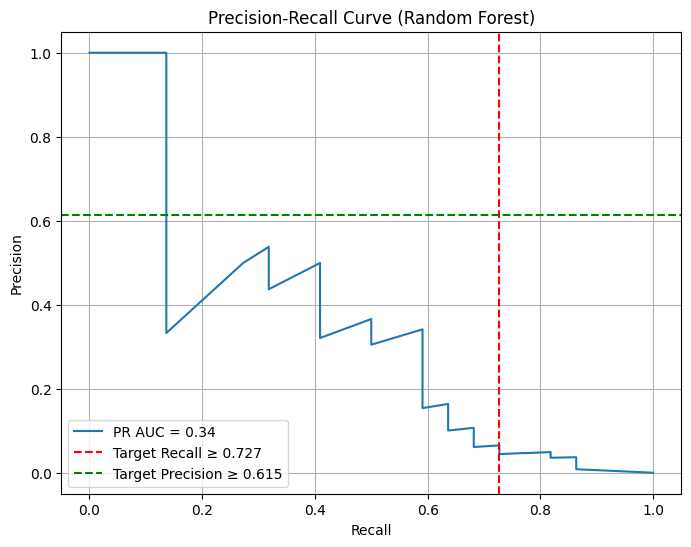

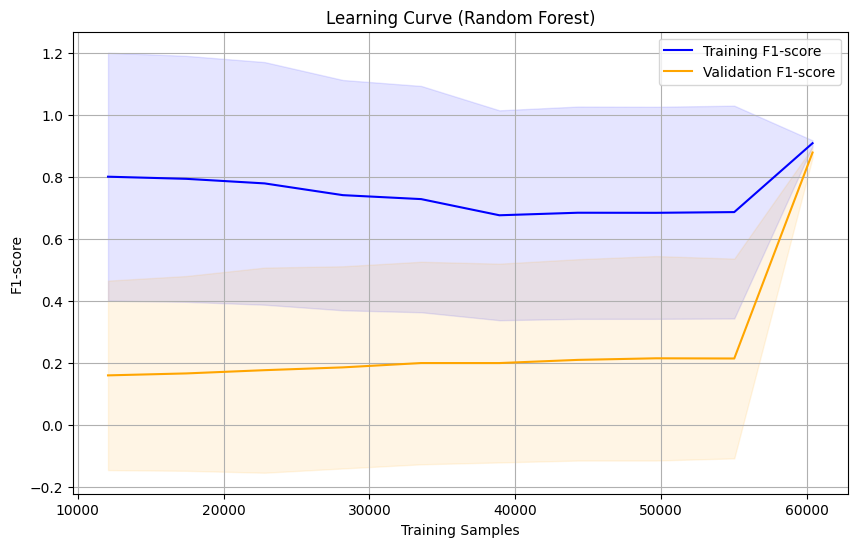

In [13]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.axvline(x=0.727, color='r', linestyle='--', label='Target Recall ≥ 0.727')
plt.axhline(y=0.615, color='g', linestyle='--', label='Target Precision ≥ 0.615')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train_scaled, y_train_smote, 
    cv=5, scoring=f1_scorer, n_jobs=-1, 
    train_sizes=np.linspace(0.2, 1.0, 10)  
)

# Replace NaN values with 0 to ensure proper plotting
train_scores = np.nan_to_num(train_scores, nan=0.0)
val_scores = np.nan_to_num(val_scores, nan=0.0)

# Calculate mean and std deviation for shading
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training F1-score', color='blue')
plt.plot(train_sizes, val_mean, label='Validation F1-score', color='orange')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
plt.xlabel('Training Samples')
plt.ylabel('F1-score')
plt.title('Learning Curve (Random Forest)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

 # Random Forest Model 4 Building (ADA + SMOTE balancing) 
 # Grid search 

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, make_scorer
import numpy as np

# Define parameter grid
param_grid = {
    'n_estimators': [50, 80, 100],        # Number of trees in the forest
    'max_depth': [10, 15, 20],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'class_weight': [{0: 1, 1: 30}, {0: 1, 1: 50}, {0: 1, 1: 70}],  # Adjusting class imbalance
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Custom F1 scorer to optimize for fraud detection
f1_scorer = make_scorer(f1_score, zero_division=0)

# Apply Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    rf_model, param_grid, scoring=f1_scorer, cv=5, n_jobs=-1, verbose=2
)

# Fit Grid Search to training data
print("\n Running Grid Search for Hyperparameter Tuning...")
grid_search.fit(X_train_scaled, y_train_smote)

# Get the best parameters
best_params = grid_search.best_params_
print("\n Best Parameters Found:", best_params)

# Train final model with best parameters
best_rf_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_rf_model.fit(X_train_scaled, y_train_smote)

# Evaluate on Test Set
y_scores = best_rf_model.predict_proba(X_test_scaled_df)[:, 1]
y_pred_adjusted = (y_scores >= 0.89).astype(int)

print("\n Optimized Random Forest Results with Threshold 0.89:")
print(classification_report(y_test, y_pred_adjusted, zero_division=0))



 Running Grid Search for Hyperparameter Tuning...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

 Best Parameters Found: {'class_weight': {0: 1, 1: 30}, 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}

 Optimized Random Forest Results with Threshold 0.89:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19978
           1       0.62      0.59      0.60        22

    accuracy                           1.00     20000
   macro avg       0.81      0.80      0.80     20000
weighted avg       1.00      1.00      1.00     20000



# Evaluation RF Model 4

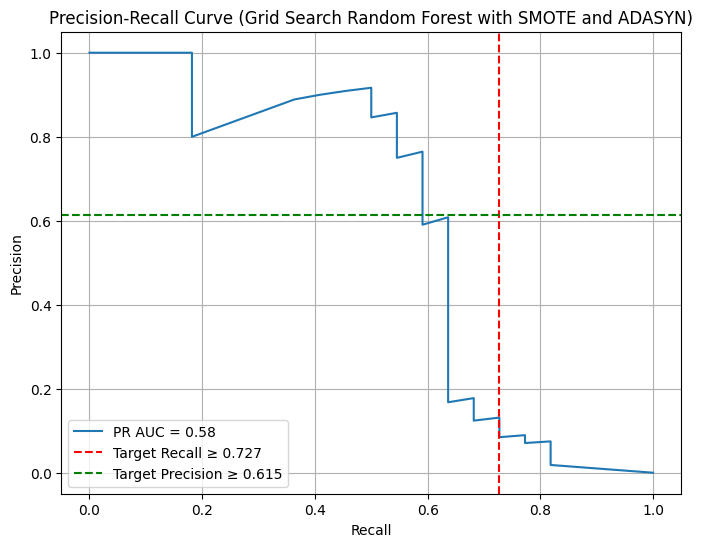

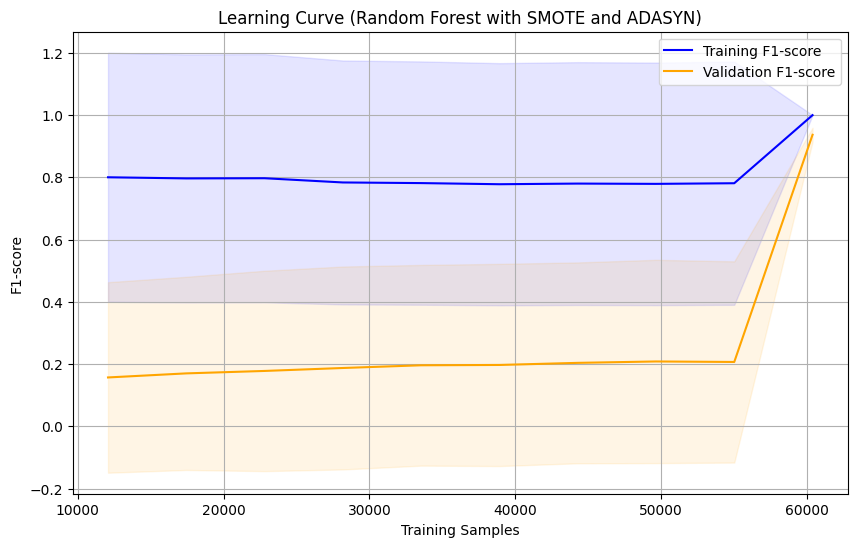

In [22]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.axvline(x=0.727, color='r', linestyle='--', label='Target Recall ≥ 0.727')
plt.axhline(y=0.615, color='g', linestyle='--', label='Target Precision ≥ 0.615')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Grid Search Random Forest with SMOTE and ADASYN)')
plt.legend()
plt.grid(True)
plt.show()


# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train_scaled, y_train_smote, 
    cv=5, scoring=f1_scorer, n_jobs=-1, 
    train_sizes=np.linspace(0.2, 1.0, 10)  
)

# Replace NaN values with 0 to ensure proper plotting
train_scores = np.nan_to_num(train_scores, nan=0.0)
val_scores = np.nan_to_num(val_scores, nan=0.0)

# Calculate mean and std deviation for shading
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training F1-score', color='blue')
plt.plot(train_sizes, val_mean, label='Validation F1-score', color='orange')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
plt.xlabel('Training Samples')
plt.ylabel('F1-score')
plt.title('Learning Curve (Random Forest with SMOTE and ADASYN)')
plt.legend(loc='best')
plt.grid(True)
plt.show()
